# Временные ряды. Разные взгляды на одно и то же

В данном jupyter notebook мы начнем погружение в мир автоматического машинного обучения для задач на временных рядах.

Однако чтобы хорошо разобраться в автоматическом инструментарии, сначала мы рассмотрим три парадигмы (подхода) в соответсвии с которыми разрабатываются AutoML подходы к обработке временных рядов.
Это не классификация (по крайней мере не настоящая), а скорее слабо очерченное шахматное поле которое мы будем постепенно заполнять фигурами (методами предобработки и модялми). Это не является классификацией еще и потому что границы между парадигмами размыты и одна не исключает другую (например, нестационарный временной ряд можно различить и на коррелограмме и на спектрограмме). Поэтому смотрите на предоставленный в данной тетрадке материал как авторское видение темы обработки временных рядов **в контексте AutoML**.

Но все начинается с данных. 

И поэтому, обращайте внимание на: 
- то как (с помощью какого кода) синтезируются временные ряды
- то как такие ряды выглядят и какими свойствами обладают

не обращайте внимание на: 
- тот код который помогает отрисовывать графики и анимации

## Определение 

Временной ряд - это набор наблюдений, упорядоченных во времени

Так давайте посмотрим на то какие они бывают!

<img src="../data/all_simple_synthetic_dataset_for_learning.png" alt="Time series dataset" width="500">

Оглавление:

- Статистико-модельная парадигма
   - Изменения математического ожидания
   - Изменения дисперсии
   - Более сложные формы нестационарности
   - Декомпозиция временных рядов
   - Траекторная матрица
- Частотно-спектральная парадигма
   - Фурье преобразование 
   - Вейвлет преобразование
- Геометрическая (shape-based) парадигма
   - Shapelet
   - SAX

За виртуальным окружением смотрите в /pyproject.toml и /poetry.lock

И помните, https://devguide.python.org/versions/

In [1]:
import random
import numpy as np
import pandas  as pd
from pathlib import Path

import matplotlib.pyplot as plt

SEED = 1000
random.seed(SEED)
np.random.seed(SEED)
rng = np.random.default_rng(SEED)  

Поскольку, это набор, упорядоченных по времени, сгенерируем временную шкалу на 100 обьектов

In [2]:
start: str = "2025-01-01"
freq: str = "D"
n: int = 100

datetime_index = pd.date_range(start=start, periods=n, freq=freq)
t = np.arange(n)

А теперь сгенерируем "временной ряд" где каждый последующий элемент случаен

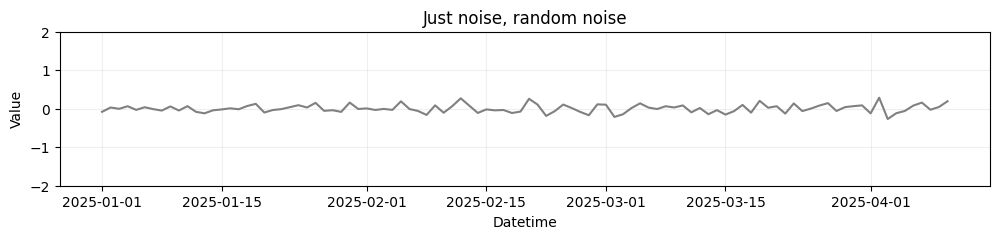

In [3]:
noise_component_scale = 0.1
noise_values = np.random.normal(0, noise_component_scale, n)

fig_size = (12.0, 2.0)
fig, ax = plt.subplots(figsize=fig_size)
ax.plot(datetime_index, noise_values, c="grey")
ax.grid(alpha=0.2)
ax.set_xlabel("Datetime")
ax.set_ylabel("Value")
ax.set_ylim(-2, 2)
ax.set_title("Just noise, random noise")
plt.show()

Такой "временной ряд" состоит из шума и только 

Но есть и более интересные варианты.

## 1. Статистико-модельная парадигма

В рамках этого взгляда на временной ряд мы оперируем статистиками (среднее, дисперсия, автокорреляция на разных участках) и смотрим на то как они изменеяются со временем.

И потому сначала поговорим про стационарность 

### Изменения математического ожидания 

#### Сезонность

> Сезонная компонента во временном ряду - это часть изменений,
которая повторяется с постоянной периодичностью во времени
(например, раз в сутки, раз в неделю, раз в год)

© Box, G. E. P., Jenkins, G. M., Reinsel, G. C., & Ljung, G. M. (2016). Time Series Analysis: Forecasting and Control (5th ed.). Wiley. глава 2.3 "The Components of a Time Series", стр. 36–38

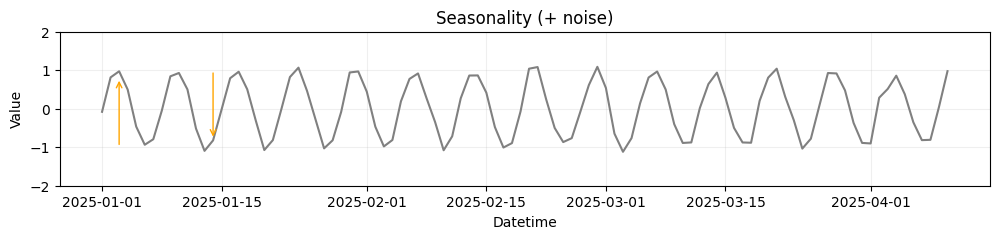

In [4]:
def get_ts_with_season():
    # Let's simulate week seasonality
    m = 7
    values = np.sin(2 * np.pi * t / m) + noise_values
    return values 

def plot_ts_with_season(ts_with_season):
    fig_size = (12.0, 2.0)
    fig, ax = plt.subplots(figsize=fig_size)
    ax.plot(datetime_index, ts_with_season, c="grey")
    ax.grid(alpha=0.2)
    ax.set_xlabel("Datetime")
    ax.set_ylabel("Value")
    ax.set_ylim(-2, 2)
    ax.set_title("Seasonality (+ noise)")
    x_up = datetime_index[2]
    ax.annotate('', xy=(x_up, 0.8), xytext=(x_up, -1), arrowprops=dict(arrowstyle='->', color='orange', lw=1))
    x_down = datetime_index[13]
    ax.annotate('', xy=(x_down, 1), xytext=(x_down, -0.8), arrowprops=dict(arrowstyle='<-', color='orange', lw=1))
    plt.show()

ts_with_season = get_ts_with_season()
plot_ts_with_season(ts_with_season)

#### Циклы

> Циклическая компонента (или циклы) во временном ряду -
это часть колебаний, отражающая долгосрочные волнообразные изменения вокруг тренда,
которые не имеют фиксированной длины периода

© Box, G. E. P., Jenkins, G. M., Reinsel, G. C., & Ljung, G. M. (2016).
Time Series Analysis: Forecasting and Control (5th ed.).
Wiley. глава 2.3 “The Components of a Time Series”, стр. 37–39.

© Chatfield, C. (2003). The Analysis of Time Series: An Introduction (6th ed.).
Chapman & Hall/CRC, глава 1.3 “Trend, Seasonal and Cyclical Variation”.

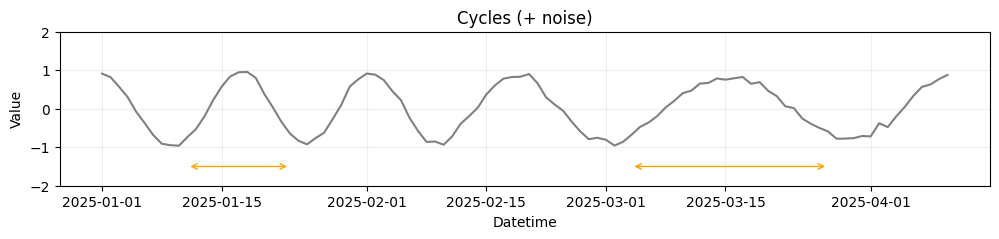

In [5]:
def get_ts_with_cycles():
    freq_base = 1 / 20
    freq_variation = 1 / 60 * np.sin(2 * np.pi * t / n)
    instantaneous_freq = freq_base + freq_variation
    phase = 2 * np.pi * np.cumsum(instantaneous_freq)
    values = np.cos(phase) * np.exp(-t / 400) + noise_values * 0.5
    return values

ts_with_cycles = get_ts_with_cycles()

fig_size = (12.0, 2.0)
fig, ax = plt.subplots(figsize=fig_size)
ax.plot(datetime_index, ts_with_cycles, c="grey")
ax.grid(alpha=0.2)
ax.set_xlabel("Datetime")
ax.set_ylabel("Value")
ax.set_ylim(-2, 2)
ax.set_title("Cycles (+ noise)")
x_start = datetime_index[10]
x_end = datetime_index[22]
ax.annotate('', xy=(x_start, -1.5), xytext=(x_end, -1.5), 
            arrowprops=dict(arrowstyle='<->', color='orange', lw=1))
x_start = datetime_index[62]
x_end = datetime_index[85]
ax.annotate('', xy=(x_start, -1.5), xytext=(x_end, -1.5), 
            arrowprops=dict(arrowstyle='<->', color='orange', lw=1))
plt.show()

#### Тренд

> Тренд во временном ряду - это долгосрочная, устойчиво направленная компонента,
отражающая общую тенденцию изменения уровня ряда во времени
(например, рост, спад или стабильность),
не зависящую от краткосрочных колебаний и случайных флуктуаций.

© Box, G. E. P., Jenkins, G. M., Reinsel, G. C., & Ljung, G. M. (2016). Time Series Analysis: Forecasting and Control (5th ed.). Wiley. глава 2.3 "The Components of a Time Series", стр. 36–38

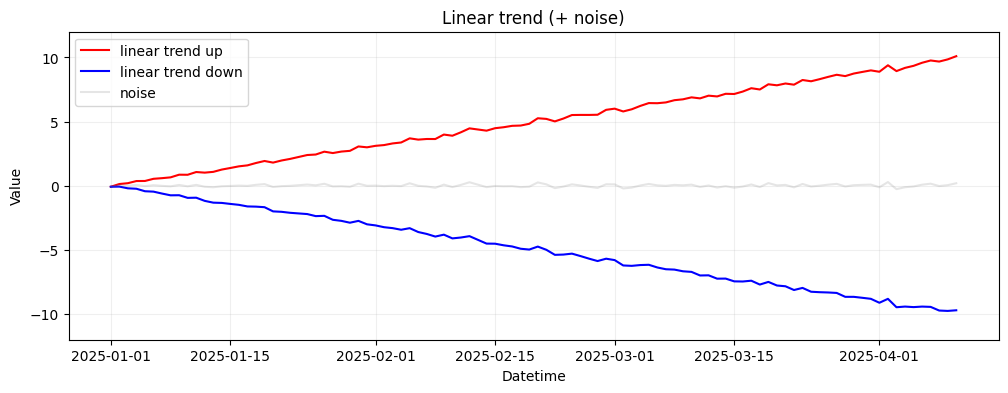

In [6]:
ts_with_linear_trend_up = 0.1 * t + noise_values
ts_with_linear_trend_down = -0.1 * t + noise_values

fig_size = (12.0, 4.0)
fig, ax = plt.subplots(figsize=fig_size)
ax.plot(datetime_index, ts_with_linear_trend_up, c="red", label="linear trend up")
ax.plot(datetime_index, ts_with_linear_trend_down, c="blue", label="linear trend down")
ax.plot(datetime_index, noise_values, c="grey", alpha=0.2, label="noise")
ax.grid(alpha=0.2)
ax.legend()
ax.set_xlabel("Datetime")
ax.set_ylabel("Value")
ax.set_ylim(-12, 12)
ax.set_title("Linear trend (+ noise)")
plt.show()

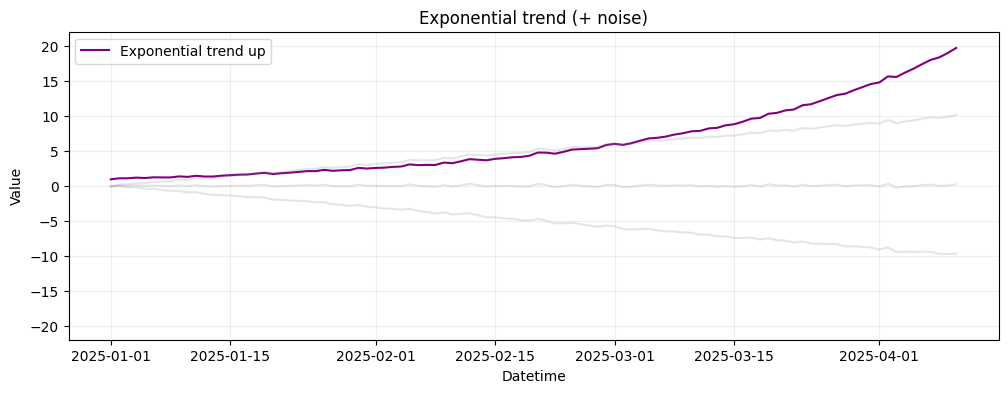

In [7]:
ts_with_exponential_trend = np.exp(0.03 * t) + noise_values

fig_size = (12.0, 4.0)
fig, ax = plt.subplots(figsize=fig_size)
ax.plot(datetime_index, ts_with_exponential_trend, c="purple", label="Exponential trend up")
ax.plot(datetime_index, ts_with_linear_trend_up, c="grey", alpha=0.2)
ax.plot(datetime_index, ts_with_linear_trend_down, c="grey", alpha=0.2)
ax.plot(datetime_index, noise_values, c="grey", alpha=0.2)
ax.grid(alpha=0.2)
ax.legend()
ax.set_xlabel("Datetime")
ax.set_ylabel("Value")
ax.set_ylim(-22, 22)
ax.set_title("Exponential trend (+ noise)")
plt.show()

#### Переключения режима (структурные сдвиги)*

*эта категория может быть частным случаем тренда, сезонности или других нестационарностей во временном ряду.

> Структурный сдвиг во временном ряду -
это внезапное изменение статистических свойств ряда
(например, среднего уровня, дисперсии или характера зависимости между наблюдениями),
происходящее в определённый момент времени
вследствие изменения внешних условий или внутренних характеристик исследуемого процесса.

© Gujarati, D. N., & Porter, D. C. (2009).
Basic Econometrics (5th ed.). McGraw-Hill, глава 12:
Structural Change and Dummy Variables.

© Hamilton, J. D. (1994). Time Series Analysis. Princeton University Press — раздел 22.1 Structural Breaks.

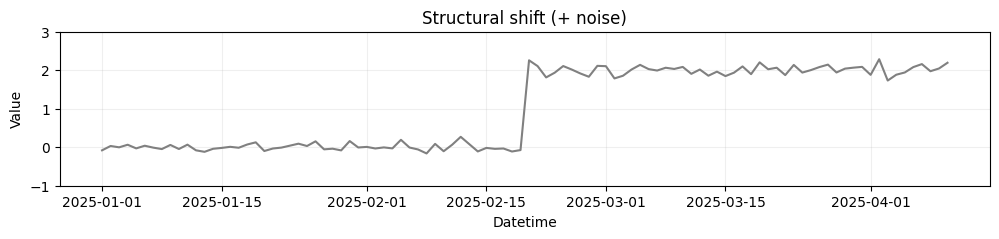

In [8]:
shift_point = n // 2
values = noise_values.copy()
values[shift_point:] += 2.0

fig_size = (12.0, 2.0)
fig, ax = plt.subplots(figsize=fig_size)
ax.plot(datetime_index, values, c="grey")
ax.grid(alpha=0.2)
ax.set_xlabel("Datetime")
ax.set_ylabel("Value")
ax.set_ylim(-1, 3)
ax.set_title("Structural shift (+ noise)")
plt.show()

#### Изменение в дисперсии

Изменение дисперсии (change in variance) означает, что разброс значений временного ряда во времени непостоянен

*Если вдруг ~никогда не знали~ забыли что такое дисперсия

> Дисперсия - это числовая характеристика случайной величины, показывающая, насколько сильно значения отклоняются от своего среднего.

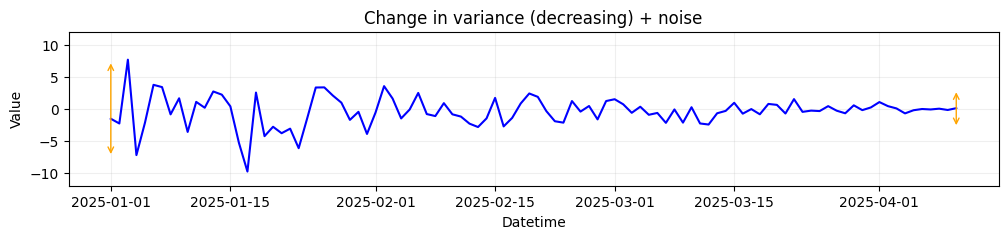

In [9]:
eps = np.random.normal(0, 2, n)
std_schedule = np.linspace(20, 0.5, n)
values = (0.1 * std_schedule) * eps

fig_size = (12.0, 2.0)
fig, ax = plt.subplots(figsize=fig_size)
ax.plot(datetime_index, values, c="blue")
ax.grid(alpha=0.2)
ax.set_xlabel("Datetime")
ax.set_ylabel("Value")
ax.set_ylim(-12, 12)
ax.set_title("Change in variance (decreasing) + noise")
x_left = datetime_index[0]
ax.annotate('', xy=(x_left, 7.5), xytext=(x_left, -7.5), arrowprops=dict(arrowstyle='<->', color='orange', lw=1))
x_right = datetime_index[-1]
ax.annotate('', xy=(x_right, 3), xytext=(x_right, -3),  arrowprops=dict(arrowstyle='<->', color='orange', lw=1))
plt.show()

In [10]:
first_10 = values[:10]
last_10 = values[-10:]

var_first = np.var(first_10)
var_last = np.var(last_10)

print(f"Variance (first 10): {var_first:.2f}")
print(f"Variance (last 10):  {var_last:.2f}")

Variance (first 10): 16.47
Variance (last 10):  0.19


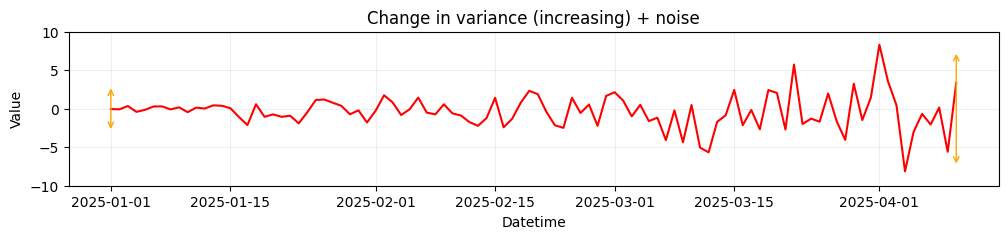

In [11]:
std_schedule = np.linspace(0.5, 20, n)
values = (0.1 * std_schedule) * eps

fig_size = (12.0, 2.0)
fig, ax = plt.subplots(figsize=fig_size)
ax.plot(datetime_index, values, c="red")
ax.grid(alpha=0.2)
ax.set_xlabel("Datetime")
ax.set_ylabel("Value")
ax.set_ylim(-10, 10)
ax.set_title("Change in variance (increasing) + noise")
x_left = datetime_index[0]
ax.annotate('', xy=(x_left, 3), xytext=(x_left, -3), arrowprops=dict(arrowstyle='<->', color='orange', lw=1))
x_right = datetime_index[-1]
ax.annotate('', xy=(x_right, 7.5), xytext=(x_right, -7.5),  arrowprops=dict(arrowstyle='<->', color='orange', lw=1))
plt.show()

#### Более сложные формы нестационарности

> Корреляция - это статистическая мера, показывающая, насколько и в каком направлении связаны две случайные величины.

> Автокорреляция - это корреляция ряда с самим собой, но со сдвигом (лагом) во времени.

Как рассчитывается aвтокорреляция на примере предыдущего ряда

In [12]:
import ipywidgets as widgets
from ipywidgets import interact


def plot_lag_pairs(values, t, lag=3):
    n = len(values)
    t = np.arange(n)
    lag = max(1, min(int(lag), n - 1))
    stride = 10

    cmap = plt.colormaps["coolwarm"]
    colors = [cmap(i / max(1, (n - lag))) for i in range(n - lag)]
    indices = [i for i in range(lag, n) if (i - lag) % stride == 0]

    table_data = pd.DataFrame({
        "t": [int(i) for i in indices],
        "y(t)": [values[i] for i in indices],
        f"y(t-{lag})": [values[i - lag] for i in indices]
    })

    fig = plt.figure(figsize=(15, 5))
    gs = fig.add_gridspec(1, 2, width_ratios=[3, 1])
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])

    ax1.plot(t, values, color="gray", lw=1.5, label="time series")
    ax1.scatter(t, values, color="gray", s=20, zorder=3)

    for i, color in zip(indices, [colors[i - lag] for i in indices]):
        ax1.plot([t[i - lag], t[i]], [values[i - lag], values[i]], color=color, lw=2, alpha=0.85)
        ax1.scatter([t[i - lag], t[i]], [values[i - lag], values[i]], color=color, s=50, zorder=3)
        ax1.text(t[i - lag], values[i - lag] + 0.1, f"{values[i - lag]:.2f}",
                 color=color, ha='center', va='bottom', fontsize=8, weight='bold')
        ax1.text(t[i], values[i] - 0.1, f"{values[i]:.2f}",
                 color=color, ha='center', va='top', fontsize=8, weight='bold')

    ax1.set_title(f"Autocorrelation illustration for lag={lag} (every {stride}th pair shown)", fontsize=13)
    ax1.set_xlabel("t")
    ax1.set_ylabel("y(t)")
    ax1.grid(alpha=0.2)

    ax2.axis("off")
    if len(table_data) > 0:
        table = ax2.table(
            cellText=np.round(table_data.values, 2),
            colLabels=table_data.columns,
            loc="center",
            cellLoc="center"
        )
        table.scale(1.2, 1.6)
        table.auto_set_font_size(False)
        table.set_fontsize(10)
    else:
        ax2.text(0.5, 0.5, "Нет пар для отображения", ha="center", va="center")

    plt.tight_layout()
    plt.show()

interact(
    lambda lag: plot_lag_pairs(ts_with_season, t, lag=lag),
    lag=widgets.IntSlider(value=1, min=1, max=max(2, len(values)-1), step=1, description="lag")
);

interactive(children=(IntSlider(value=1, description='lag', max=99, min=1), Output()), _dom_classes=('widget-i…

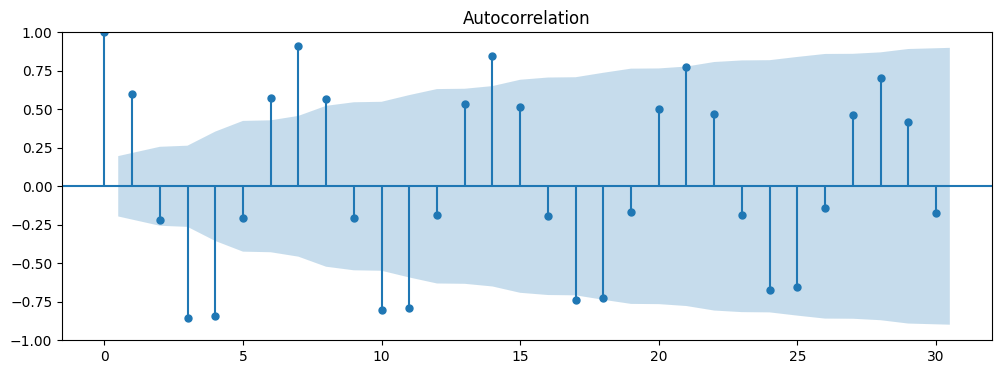

In [13]:
from statsmodels.graphics.tsaplots import plot_acf

fig, ax = plt.subplots(figsize=(12, 4))
plot_acf(ts_with_season, lags=30, ax=ax)
plt.show()

#### Сложные примеры. "Конкатенация"

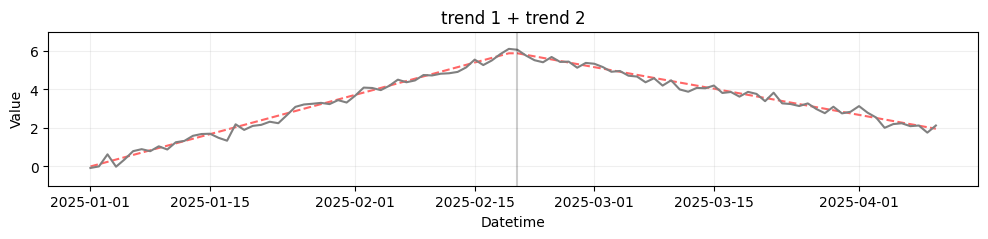

In [14]:
shift_point = n // 2
slope1, slope2 = 0.12, -0.08  # tweak as needed
trend = np.empty(n, dtype=float)
trend[:shift_point] = slope1 * np.arange(shift_point)
# Continue from the last level to avoid jumps at the kink
base_level = trend[shift_point - 1]
trend[shift_point:] = base_level + slope2 * np.arange(n - shift_point)
values = trend + 0.1 * eps

fig_size = (12.0, 2.0)
fig, ax = plt.subplots(figsize=fig_size)
ax.plot(datetime_index, trend, '--', c="red", alpha=0.6, zorder=1)
ax.plot(datetime_index, values, c="grey", zorder=2)
ax.grid(alpha=0.2)
ax.axvline(datetime_index[50], c='black', alpha=0.2)
ax.set_xlabel("Datetime")
ax.set_ylabel("Value")
ax.set_ylim(-1, 7)
ax.set_title("trend 1 + trend 2")
plt.show()

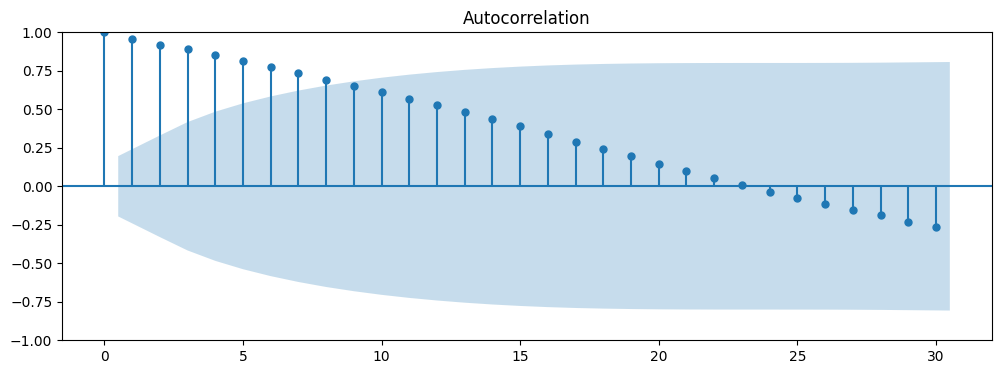

In [15]:
fig, ax = plt.subplots(figsize=(12, 4))
plot_acf(values, lags=30, ax=ax)
plt.show()

### Внимание вопрос! 

### Как будут отличаться коррелограммы для правой и левой части временного ряда? 

...

... 

...

...

...

...

...

...

...

...

...

...

...

      (•_•)
     <)   )╯   ♫  SHAKE IT!
      /   \


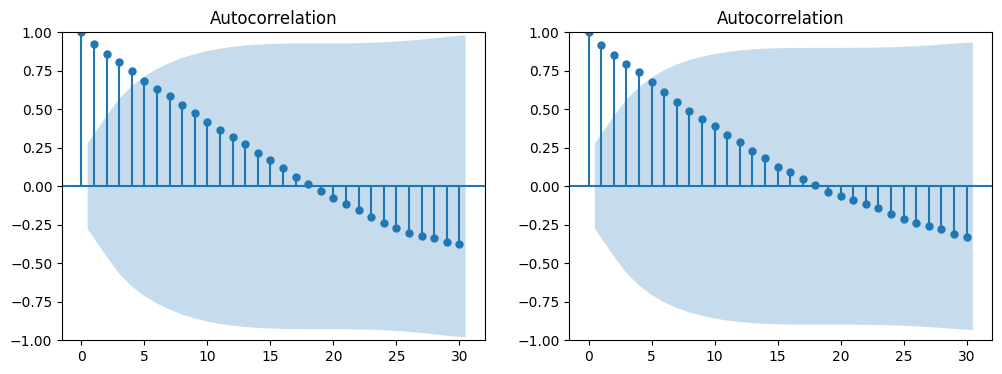

In [16]:
fig, axs = plt.subplots(ncols=2, figsize=(12, 4))
plot_acf(values[:shift_point], lags=30, ax=axs[0])
plot_acf(values[-shift_point:], lags=30, ax=axs[-1])
plt.show()

In [17]:
# If needed to explain - right part values[:shift_point] and left part values[-shift_point:]
# interact(
#     lambda lag: plot_lag_pairs(values[-shift_point:], t, lag=lag),
#     lag=widgets.IntSlider(value=3, min=1, max=max(2, len(values[-shift_point:])-1), step=1, description="lag")
# );

Но держите в голове "большую картину"

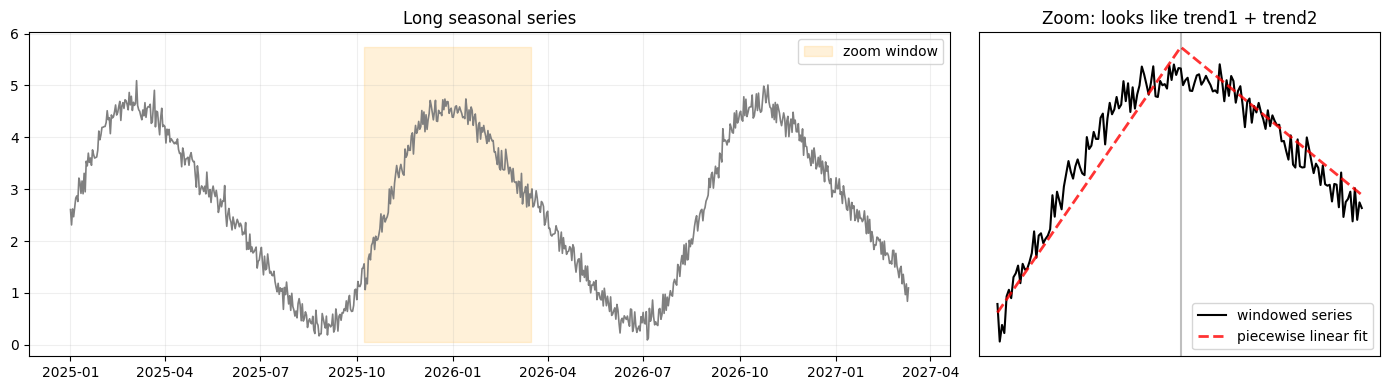

In [23]:
def show_seasonal_with_window():
    n_long = 800
    start = "2025-01-01"
    freq = "D"
    
    t = np.arange(n_long)
    dt = pd.date_range(start, periods=n_long, freq=freq)
    
    m = 300 
    season = 2.5 + 2.0 * np.sin(2 * np.pi * t / m) + 0.4 * np.sin(2 * np.pi * t / (m/2))
    noise = 0.15 * np.random.normal(size=n_long)
    values = season + noise
    
    win_start = 280
    win_len = 160
    win_end = win_start + win_len 
    t_win = np.arange(win_len)
    dt_win = dt[win_start:win_end]
    y_win = values[win_start:win_end]
    
    mid = win_len // 2
    slope1, intercept1 = np.polyfit(t_win[:mid], y_win[:mid], 1)
    slope2, intercept2_raw = np.polyfit(t_win[mid:] - t_win[mid], y_win[mid:], 1)
    y_mid_level = slope1 * mid + intercept1
    intercept2 = y_mid_level
    trend_piece = np.empty(win_len)
    trend_piece[:mid] = slope1 * t_win[:mid] + intercept1
    trend_piece[mid:] = intercept2 + slope2 * (t_win[mid:] - t_win[mid])
    
    fig, (ax_full, ax_zoom) = plt.subplots(ncols=2, figsize=(14, 4), gridspec_kw={'width_ratios':[2.3, 1]})
    
    ax_full.plot(dt, values, c="grey", lw=1.2)
    ax_full.fill_between(dt[win_start:win_end], values[win_start:win_end].min()-1, 
                         values[win_start:win_end].max()+1, color="orange", alpha=0.15, label="zoom window")
    ax_full.set_title("Long seasonal series")
    ax_full.grid(alpha=0.2)
    ax_full.legend()
    
    ax_zoom.plot(dt_win, y_win, c="black", lw=1.5, label="windowed series")
    # Subtract 0.2 because the line is too high
    ax_zoom.plot(dt_win, trend_piece - 0.2, "--", c="red", lw=2, alpha=0.8, label="piecewise linear fit")
    ax_zoom.axvline(dt_win[mid], color="black", alpha=0.25)
    ax_zoom.set_title("Zoom: looks like trend1 + trend2")
    ax_zoom.legend()
    ax_zoom.set_yticks([])
    ax_zoom.set_xticks([])
    
    plt.tight_layout()
    plt.show()

show_seasonal_with_window()

Иногда изменения в ряду не такие очевидные на первый взгляд

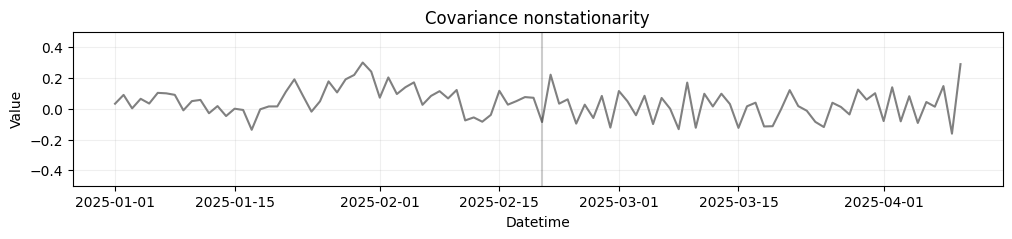

In [24]:
shift_point = n // 2
phi1, phi2 = 0.7, -0.3

# Choose innovation std so that the unconditional variance remains base_sigma^2
# For AR(1): Var(y) = sigma_e^2 / (1 - phi^2) => sigma_e = base_sigma * sqrt(1 - phi^2)
sigma_e1 = 0.1 * np.sqrt(1.0 - phi1 ** 2)
sigma_e2 = 0.1 * np.sqrt(1.0 - phi2 ** 2)

e1 = np.random.normal(0, sigma_e1, shift_point)
e2 = np.random.normal(0, sigma_e2, n - shift_point)

values = np.zeros(n)
values[0] = np.random.normal(0, 0.1)

# First regime
for i in range(1, shift_point):
    values[i] = phi1 * values[i - 1] + e1[i]

# Second regime
for i in range(shift_point, n):
    prev = values[i - 1] if i > 0 else 0.0
    values[i] = phi2 * prev + e2[i - shift_point]

fig_size = (12.0, 2.0)
fig, ax = plt.subplots(figsize=fig_size)
ax.plot(datetime_index, values, c="grey")
ax.grid(alpha=0.2)
ax.axvline(datetime_index[shift_point], c='black', alpha=0.2)
ax.set_xlabel("Datetime")
ax.set_ylabel("Value")
ax.set_ylim(-0.5, 0.5)
ax.set_title("Covariance nonstationarity")
plt.show()

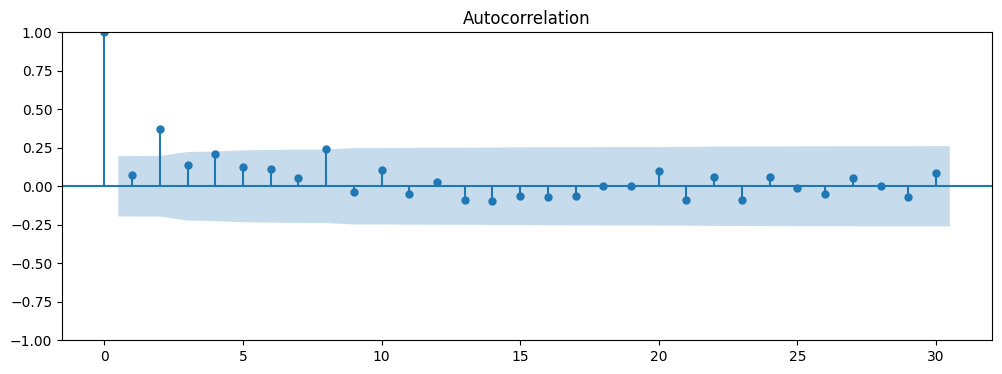

In [25]:
fig, ax = plt.subplots(figsize=(12, 4))
plot_acf(values, lags=30, ax=ax)
plt.show()

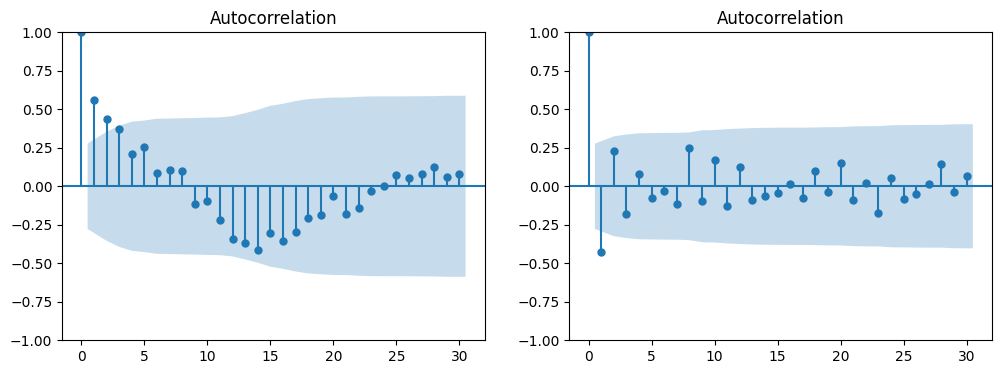

In [26]:
fig, axs = plt.subplots(ncols=2, figsize=(12, 4))
plot_acf(values[:shift_point], lags=30, ax=axs[0])
plot_acf(values[-shift_point:], lags=30, ax=axs[-1])
plt.show()

#### Обьединение компонент. Сумма

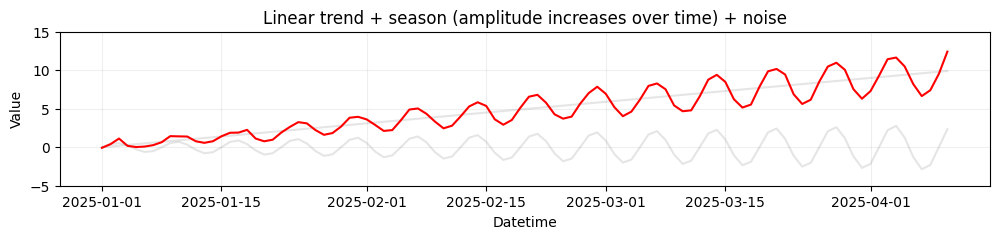

In [27]:
trend = 0.1 * t
m = 7
# Amplitude of seasonal component increases over time
amplitude = np.linspace(0.5, 3.0, n)
seasonal_with_var = amplitude * np.sin(2 * np.pi * t / m)
ts_with_linear_trend_seasonality_and_variance = trend + seasonal_with_var + 0.1 * eps

fig_size = (12.0, 2.0)
fig, ax = plt.subplots(figsize=fig_size)
ax.plot(datetime_index, trend, c="grey", alpha=0.2)
ax.plot(datetime_index, seasonal_with_var, c="grey", alpha=0.2)
ax.plot(datetime_index, ts_with_linear_trend_seasonality_and_variance, c="red")
ax.grid(alpha=0.2)
ax.set_xlabel("Datetime")
ax.set_ylabel("Value")
ax.set_ylim(-5, 15)
ax.set_title("Linear trend + season (amplitude increases over time) + noise")
plt.show()

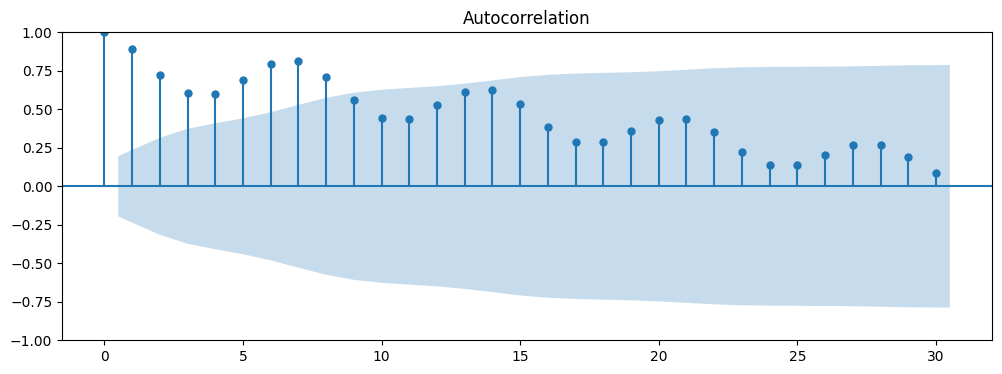

In [28]:
fig, ax = plt.subplots(figsize=(12, 4))
plot_acf(ts_with_linear_trend_seasonality_and_variance, lags=30, ax=ax)
plt.show()

#### Комбинация различных компонентов, которая неочевидна

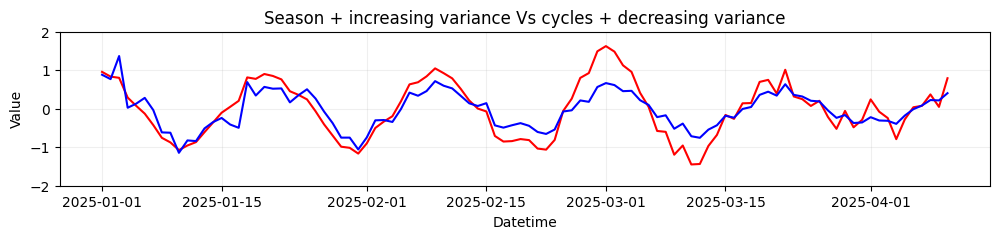

In [29]:
m_sync = 20  # common period for both series
phi = 0.2 # almost common phase

std_up = np.linspace(0.3, 1.5, n)
seasonal = np.cos(2 * np.pi * t / m_sync + phi)
half = n // 2
mask2 = t >= t[half]
m_cycle = 4 * m_sync
A = 0.6
ramp_len = max(5, int(0.1 * (n - half)))
ramp = np.linspace(0, 1, ramp_len)
window = np.ones(n)
window[half:half + ramp_len] = ramp
window[half + ramp_len:] = 1.0
t2 = t - t[half]
slow_cycle = 1.0 + A * np.cos(2 * np.pi * t2 / m_cycle)
amp = np.ones(n)
amp[mask2] = 1.0 + window[mask2] * (slow_cycle[mask2] - 1.0)
seasonal_mod = amp * seasonal
values_seasonal_var_increasing = seasonal_mod + (0.1 * std_up) * eps

std_down = np.linspace(1.5, 0.3, n)  # decreasing variance
cycles = np.cos(2 * np.pi * t / m_sync) * np.exp(-t / n)  # SAME wave + mild damping
values_cycles_var_decreasing = cycles + (0.1 * std_down) * eps

fig_size = (12.0, 2.0)
fig, ax = plt.subplots(figsize=fig_size)
ax.plot(datetime_index, values_seasonal_var_increasing, c="red")
ax.plot(datetime_index, values_cycles_var_decreasing, c="blue")
ax.grid(alpha=0.2)
ax.set_xlabel("Datetime")
ax.set_ylabel("Value")
ax.set_ylim(-2, 2)
ax.set_title("Season + increasing variance Vs cycles + decreasing variance")
plt.show()

### Попытаемся декомпозировать обратно

> STL-декомпозиция (от Seasonal-Trend decomposition using Loess) - это метод разложения временного ряда на три аддитивные компоненты: тренд, сезонность и остаток (шум), с использованием локальной регрессии (LOESS) для сглаживания.

© Cleveland, R. B., Cleveland, W. S., McRae, J. E., & Terpenning, I. (1990). STL: A Seasonal-Trend Decomposition Procedure Based on Loess. Journal of Official Statistics, 6(1), 3–73.

Сначала возьмем ряд "попроще", с сезонностью

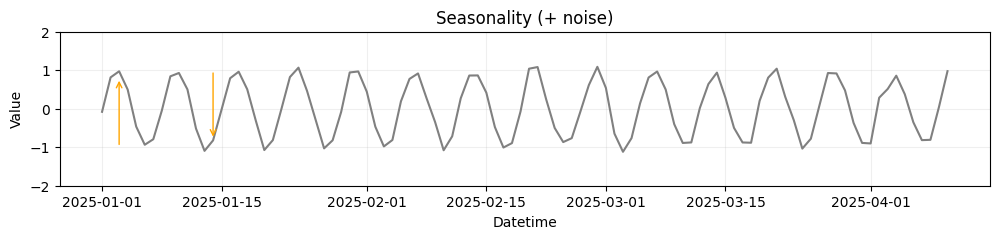

In [30]:
plot_ts_with_season(ts_with_season)

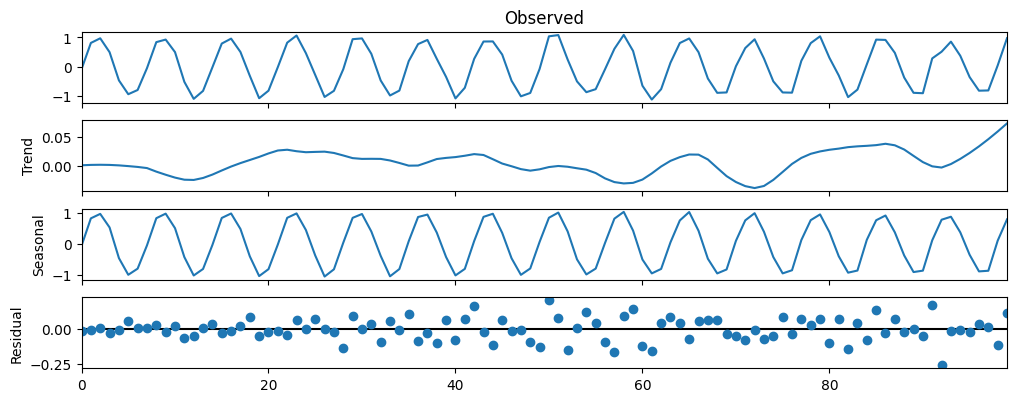

In [31]:
from statsmodels.tsa.seasonal import STL

res = STL(ts_with_season, period=m).fit()
ax = res.plot()
fig = ax.get_figure()
fig.set_size_inches(11, 4)
plt.show()

Теперь посложнее

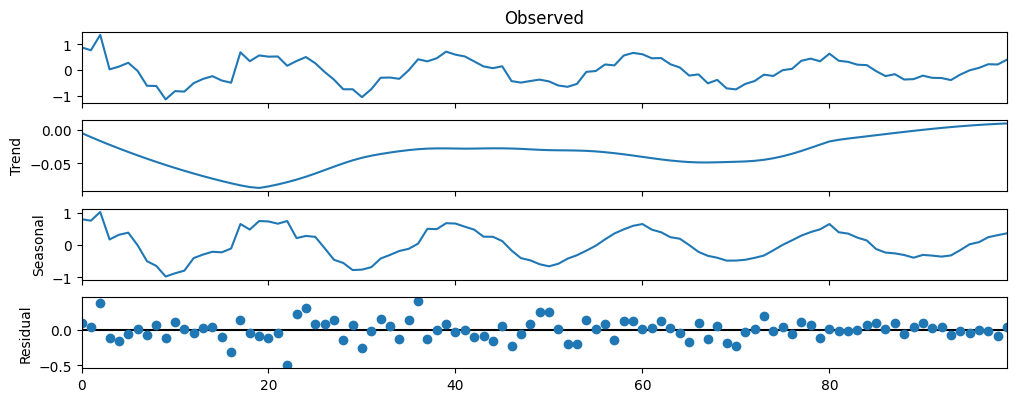

In [32]:
res = STL(values_cycles_var_decreasing, period=m_sync).fit()
ax = res.plot()
fig = ax.get_figure()
fig.set_size_inches(11, 4)
plt.show()

#### Lagged представление, или траекторная матрица

Очень популярное представление временного ряда при построении моделей машинного обучения на временных рядах

<img src="../data/lagged_animation.gif" alt="Time series dataset" width="700">


In [33]:
from numpy.lib.stride_tricks import sliding_window_view

def make_lagged(x: np.ndarray, lag: int, horizon: int = 1):
    x = np.asarray(x).reshape(-1)
    N = x.size

    W = sliding_window_view(x, lag + horizon)
    X = W[:, :lag]
    y = None
    if horizon > 0:
        Y = W[:, lag:]
        y = Y[:, 0] if horizon == 1 else Y
    return X, y


ts = np.arange(0, 10)
features, target = make_lagged(ts, lag=5, horizon=2)

print("Features - Target")
for i in range(0, len(features)): 
    print(features[i, :], '-', target[i, :])

Features - Target
[0 1 2 3 4] - [5 6]
[1 2 3 4 5] - [6 7]
[2 3 4 5 6] - [7 8]
[3 4 5 6 7] - [8 9]


Ииии мы закончили с первой парадигмой ...

## 2. Частотно-спектральная парадигма

Это мир гармоник, частот и волн

Вейвлет преобразование, Фурье преобразование, Метод разложения по динамическим модам (Dynamic Mode Decomposition) и т.д.

FFT (быстрое Фурье-преобразование) это способ разобрать сложный сигнал на простые волны (синусоиды)

Weekly seasonality: 7


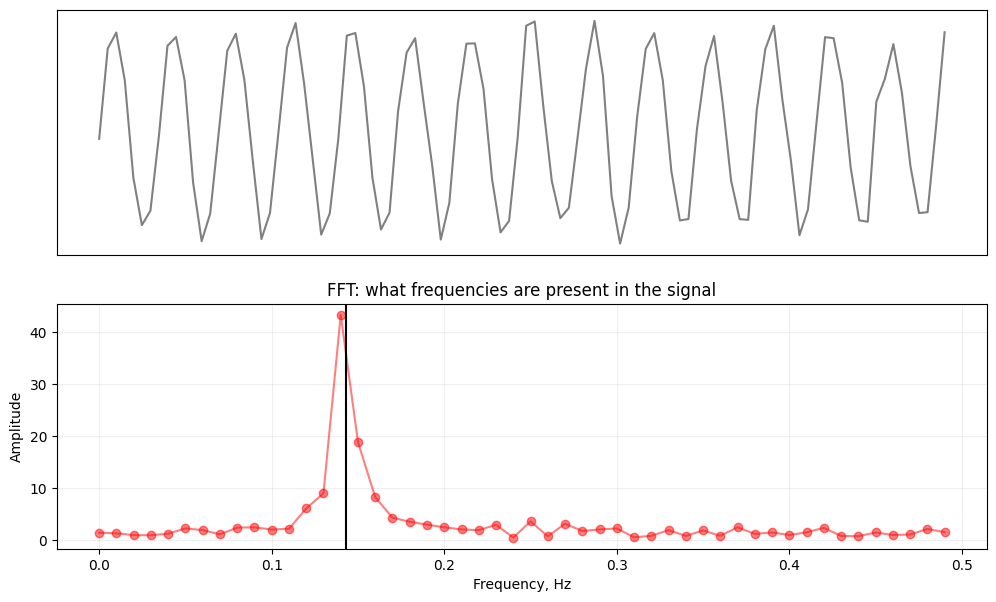

In [34]:
def calculate_fft_and_visualize(ts_to_process: np.array):
    fft_vals = np.fft.fft(ts_to_process)
    # Daily data, so d = 1 here
    freqs = np.fft.fftfreq(n, d=1)
    
    fig_size = (12.0, 7.0)
    fig, axs = plt.subplots(2, 1, figsize=fig_size)
    axs[0].plot(datetime_index, ts_to_process, c="grey")
    axs[0].set_yticks([])
    axs[0].set_xticks([])
    
    axs[1].plot(freqs[:len(freqs)//2], np.abs(fft_vals[:len(fft_vals)//2]), '-o', color='red', alpha=0.5)
    axs[1].set_xlabel("Frequency, Hz")
    axs[1].axvline(1/m, color="black")
    axs[1].set_ylabel("Amplitude")
    axs[1].grid(alpha=0.2)
    axs[1].set_title("FFT: what frequencies are present in the signal")
    plt.show()

    return freqs

print(f"Weekly seasonality: {m}")
ts_with_season_freqs = calculate_fft_and_visualize(ts_with_season)

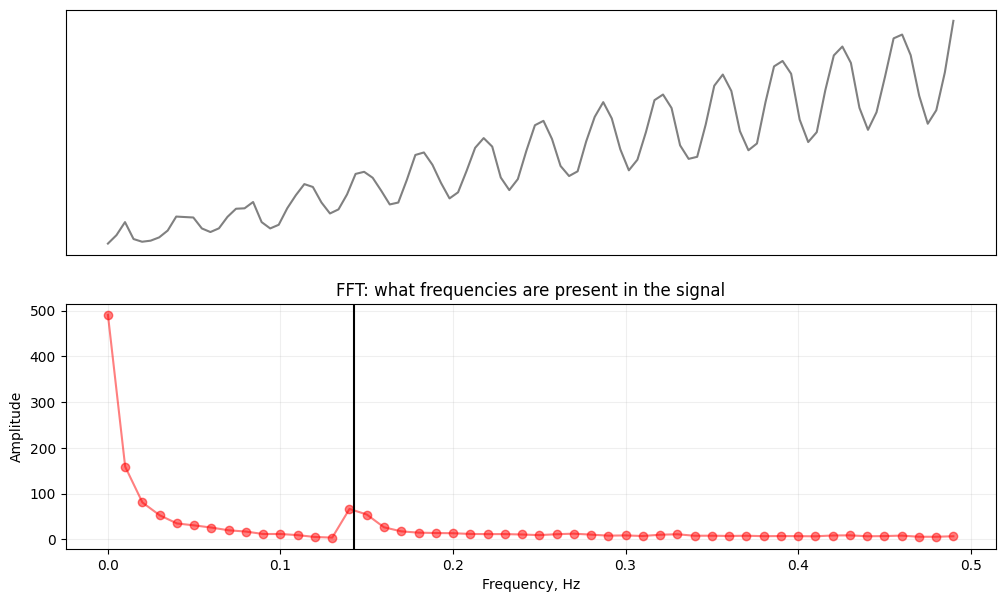

In [35]:
ts_with_linear_trend_seasonality_and_variance_freqs = calculate_fft_and_visualize(ts_with_linear_trend_seasonality_and_variance)

Это аналог перехода из временной области во "частотную область"

В итоге мы получаем:

- амплитуду - насколько сильно выражена каждая частота,
- фазу - где именно начинается волна во времени,
- частоту - сколько раз в единицу времени повторяется волна.

Мы смотрели только на амплитуды, но фазы нужны, если мы хотим восстановить сигнал обратно.

Итого, в результате преобразования мы получаем Фурье-коэффициенты - числовые “веса” (амплитуда и фаза), с которыми разные синусоиды участвуют в построении сигнала.

> “Чтобы построить этот сигнал, нужно взять синус с частотой f₁ с такой-то амплитудой и фазой, потом добавить синус f₂, f₃ и т.д.”

In [36]:
from ipywidgets import interact, IntSlider


def fft_viewer_interact(
    x: np.array,
    top_k: int = 1,
    vmin: int = -7.5,
    vmax: int = 15):
    x = np.asarray(x, dtype=float)
    n = len(x)
    t = np.arange(n)

    # Precompute FFT parts that don't change when only top_k changes
    fft_vals = np.fft.fft(x)
    freqs = np.fft.fftfreq(n, d=1)
    amp = np.abs(fft_vals) / n
    phase = np.angle(fft_vals)

    # Use only positive frequencies (exclude DC)
    pos = freqs > 0
    freqs_pos = freqs[pos]
    amp_pos = amp[pos]
    phase_pos = phase[pos]

    # Guard: if series too short
    if freqs_pos.size == 0:
        raise ValueError("No positive frequencies found. Provide a longer time series.")

    def _plot(top_k):
        k_eff = int(max(1, min(top_k, freqs_pos.size)))

        # Select top-k by amplitude
        idx_sorted = np.argsort(amp_pos)[::-1][:k_eff]
        top_freqs = freqs_pos[idx_sorted]

        # Reconstruct components (one-sided reconstruction: multiply inner freqs by 2)
        components = []
        for f in top_freqs:
            k = np.argmin(np.abs(freqs - f)) 
            comp = (2 * amp[k]) * np.cos(2 * np.pi * f * t + phase[k])
            components.append((f, comp))

        # Sum of components
        reconstructed_sum = np.zeros_like(t, dtype=float)
        for _, comp in components:
            reconstructed_sum += comp

        plt.figure(figsize=(10, 6))

        # 1) Original series 
        plt.plot(t, x, color="grey", alpha=0.5, label="Original series")

        # 2) Sum of components in red
        plt.plot(t, reconstructed_sum, color="red", linewidth=2.0, zorder=2,
                 label=f"Sum of top-{k_eff} components")

        # 3) Individual components in pre-defined palette
        palette = plt.cm.Paired(np.linspace(0, 1, max(len(components), 1)))
        for i, (f, comp) in enumerate(components):
            period = 1 / abs(f) if f != 0 else np.inf
            plt.plot(t, comp, color=palette[i], linewidth=1.2, linestyle='dashed',
                     label=f"f={f:.3f} (T≈{period:.1f})", zorder=1)

        plt.title(f"Top-{k_eff} FFT harmonics: individual components and their sum")
        plt.xlabel("Time index")
        plt.ylabel("Amplitude")
        plt.ylim(vmin, vmax)
        plt.grid(True, alpha=0.3)
        plt.legend(ncol=2, loc="upper left")
        plt.tight_layout()
        plt.show()

    # Interact over top_k only; pass array x directly by calling this function again with another x
    interact(
        _plot,
        top_k=IntSlider(value=int(top_k), min=1, max=min(20, freqs_pos.size), step=1, description="Top-k")
    )

fft_viewer_interact(ts_with_linear_trend_seasonality_and_variance)

interactive(children=(IntSlider(value=1, description='Top-k', max=20, min=1), Output()), _dom_classes=('widget…

Описывается не очень хорошо, но вот что будет если мы "исключим" тренд и будем работать только с следующими компонентами

- сезонность
- увеличивающаяся дисперсия
- шум

In [37]:
fft_viewer_interact(seasonal_with_var, vmin=-4, vmax=7)

interactive(children=(IntSlider(value=1, description='Top-k', max=20, min=1), Output()), _dom_classes=('widget…

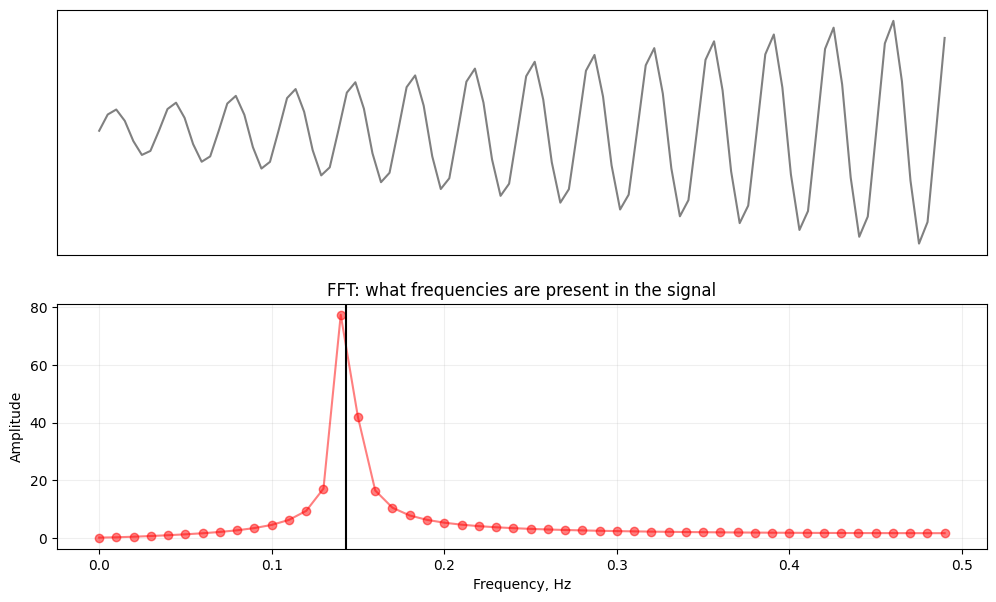

In [38]:
_ = calculate_fft_and_visualize(seasonal_with_var)

Фурье-преобразование достойно работает на стационарных сигналах, когда частотный состав не меняется со временем.

Как мы видели выше, когда ряд нестационарен сразу по нескольким уровням, восстановить исходный ряд из гармоник получется плохо.

**Вейвлет-преобразование** - это метод, который, как и Фурье-преобразование, разбивает сигнал на составляющие, но делает это не только по частотам, а ещё и по времени.

Если ряд меняется во времени — например:

- появляются кратковременные пики,
- сезонность со временем слабеет или усиливается,
- структура сигнала меняется 

то Фурье-преобразование размажет всё по частотам и не покажет, когда это произошло.

Вейвлет-преобразование показывает временную локализацию частот когда и на каком масштабе они были активны.

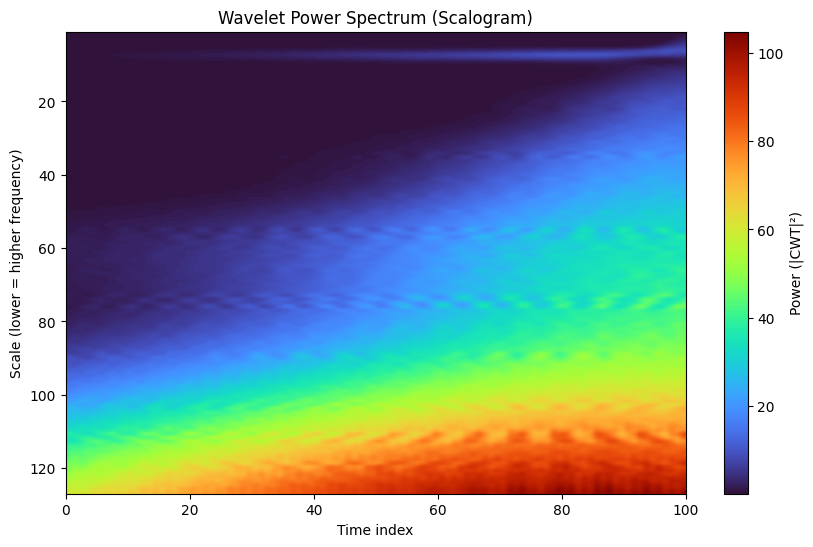

In [39]:
import pywt

# Continuous Wavelet Transform (CWT)
wavelet = 'cmor1.5-1.0'  # Complex Morlet wavelet
scales = np.arange(1, 128)
coefficients, freqs = pywt.cwt(ts_with_linear_trend_seasonality_and_variance, scales, wavelet)

# Power spectrum (magnitude squared)
power = np.abs(coefficients) ** 2

# Visualization
plt.figure(figsize=(10, 6))
plt.imshow(
    power, extent=[0, n, scales.max(), scales.min()],
    cmap='turbo', aspect='auto', interpolation="quadric"
)
plt.colorbar(label='Power (|CWT|²)')
plt.xlabel('Time index')
plt.ylabel('Scale (lower = higher frequency)')
plt.title('Wavelet Power Spectrum (Scalogram)')
plt.show()

Как читать график 

Верхняя часть (scale < 20) - почти чёрно-фиолетовая. Это значит, быстрых колебаний в сигнале почти нет,
т.е. нет резких пиков, шум слабый.

Нижняя часть (scale ≈ 80–120) - красно-оранжевая. Значит, есть сильная низкочастотная компонента,
т.е. сигнал медленно растёт или колеблется с большим периодом.

Переход от синего к красному к концу времени (по X). Это говорит, что амплитуда или масштаб колебаний увеличивается со временем.

Например:

- либо тренд усиливается,
- либо сезонность становится “длиннее” и сильнее,
- либо вариации (дисперсия) растут.

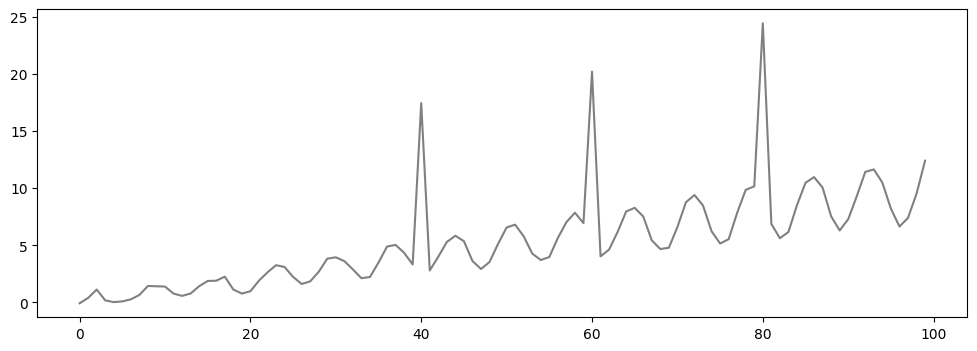

In [40]:
for i in [40, 60, 80]:
    current_value = ts_with_linear_trend_seasonality_and_variance[i]
    current_value = current_value + 15
    ts_with_linear_trend_seasonality_and_variance[i] = current_value
        
plt.figure(figsize=(12, 4))
plt.plot(ts_with_linear_trend_seasonality_and_variance, color='grey')
plt.show()

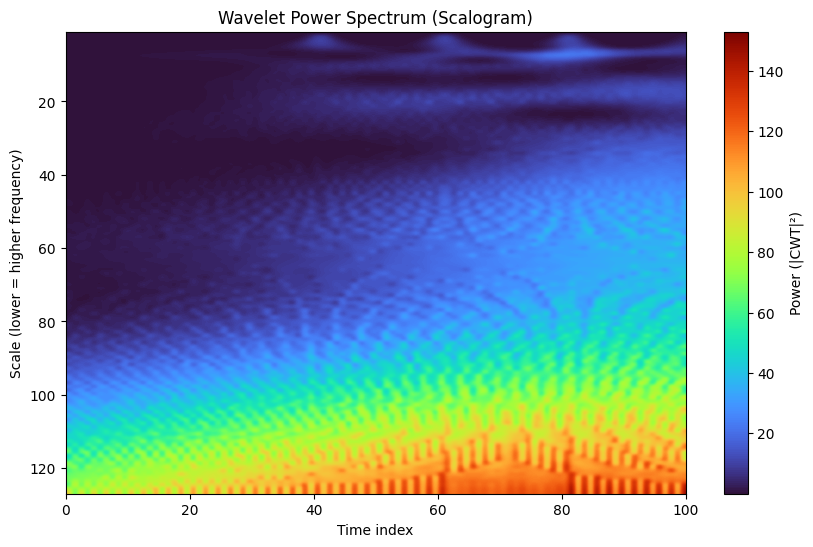

In [41]:
wavelet = 'cmor1.5-1.0'
scales = np.arange(1, 128)
coefficients, freqs = pywt.cwt(ts_with_linear_trend_seasonality_and_variance, scales, wavelet)
power = np.abs(coefficients) ** 2

plt.figure(figsize=(10, 6))
plt.imshow(
    power, extent=[0, n, scales.max(), scales.min()],
    cmap='turbo', aspect='auto', interpolation="quadric"
)
plt.colorbar(label='Power (|CWT|²)')
plt.xlabel('Time index')
plt.ylabel('Scale (lower = higher frequency)')
plt.title('Wavelet Power Spectrum (Scalogram)')
plt.show()

Как дополнение, можете продолжить тему, например с 

Методом разложения по динамическим модам (Dynamic Mode Decomposition)

## 3. Геометрическая (shape-based) парадигма

### Shapelet

> Shapelet - это небольшой фрагмент (подпоследовательность) временного ряда, который является характерным шаблоном (формой), помогающим отличать один тип поведения от другого.

© Ye & Keogh, 2009, Time Series Shapelets: A New Primitive for Data Mining

#### Зачем

Есть набор временных рядов (например, ЭКГ здоровых и больных пациентов, или сенсорные данные нормальной и аварийной работы оборудования). 
Мы можем искать формы, которые:

- часто появляются в одном классе,
- и почти не встречаются в другом.

Эти формы и есть шейплеты (shapelets).

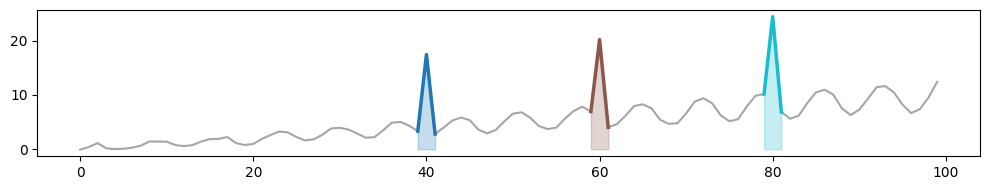

In [42]:
import numpy as np
import matplotlib.pyplot as plt


def find_and_plot_triplet_shapes(x, time=None, window=11, k=4.0, min_distance=5, show=True):
    x = np.asarray(x, float).reshape(-1)
    n = len(x)
    w = int(max(3, window))
    ma = np.convolve(x, np.ones(w)/w, mode='same')
    resid = x - ma
    med = np.median(resid)
    mad = np.median(np.abs(resid - med)) + 1e-12
    z = (resid - med) / (1.4826 * mad)
    cands = np.arange(1, n-1)[(z[1:-1] > k) & (resid[1:-1] > resid[:-2]) & (resid[1:-1] > resid[2:]) &
                              (z[:-2] < k/2) & (z[2:] < k/2)]
    peaks = []
    for i in cands:
        left = max(1, i - min_distance)
        right = min(n-1, i + min_distance + 1)
        if resid[i] == np.max(resid[left:right]):
            peaks.append(i)
    peaks = np.array(sorted(set(peaks)))
    triplets = np.vstack([peaks-1, peaks, peaks+1]).T if peaks.size else np.empty((0,3), int)
    if show:
        t = np.arange(n) if time is None else np.asarray(time)
        plt.figure(figsize=(10,2))
        plt.plot(t, x, color="gray", alpha=0.7)
        cmap = plt.cm.tab10(np.linspace(0,1,len(peaks)))
        for j,i in enumerate(peaks):
            if 1 <= i < n-1:
                seg_t = t[i-1:i+2]
                seg_x = x[i-1:i+2]
                plt.plot(seg_t, seg_x, color=cmap[j], linewidth=2.5)
                plt.fill_between(seg_t, seg_x, color=cmap[j], alpha=0.25)
        plt.tight_layout()
        plt.show()
    return {"centers": peaks, "triplets": triplets}


motifs = find_and_plot_triplet_shapes(ts_with_linear_trend_seasonality_and_variance)

### SAX

SAX (Symbolic Aggregate approXimation) - это один способов символьного (дискретного) представления временных рядов

SAX превращает непрерывный временной ряд (набор чисел) в цепочку символов (строку), например "abccddbbac".

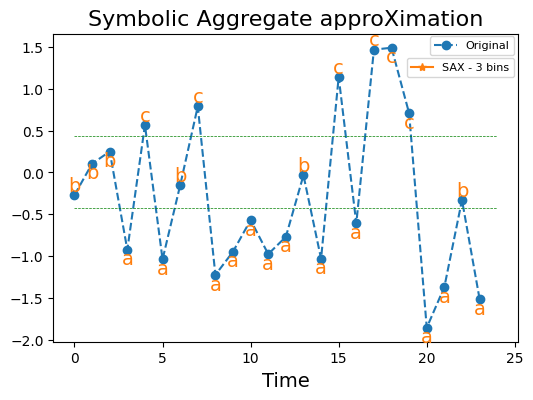

In [43]:
import numpy as np
from scipy.stats import norm

import matplotlib.lines as mlines
from pyts.approximation import SymbolicAggregateApproximation

# Parameters
n_samples, n_timestamps = 100, 24

# Toy dataset
rng = np.random.RandomState(41)
X = rng.randn(n_samples, n_timestamps)

# SAX transformation
n_bins = 3
sax = SymbolicAggregateApproximation(n_bins=n_bins, strategy='normal')
X_sax = sax.fit_transform(X)

# Compute gaussian bins
bins = norm.ppf(np.linspace(0, 1, n_bins + 1)[1:-1])

# Show the results for the first time series
bottom_bool = np.r_[True, X_sax[0, 1:] > X_sax[0, :-1]]

plt.figure(figsize=(6, 4))
plt.plot(X[0], 'o--', label='Original')
for x, y, s, bottom in zip(range(n_timestamps), X[0], X_sax[0], bottom_bool):
    va = 'bottom' if bottom else 'top'
    plt.text(x, y, s, ha='center', va=va, fontsize=14, color='#ff7f0e')
plt.hlines(bins, 0, n_timestamps, color='g', linestyles='--', linewidth=0.5)
sax_legend = mlines.Line2D([], [], color='#ff7f0e', marker='*',
                           label='SAX - {0} bins'.format(n_bins))
first_legend = plt.legend(handles=[sax_legend], fontsize=8, loc=(0.76, 0.86))
ax = plt.gca().add_artist(first_legend)
plt.legend(loc=(0.81, 0.93), fontsize=8)
plt.xlabel('Time', fontsize=14)
plt.title('Symbolic Aggregate approXimation', fontsize=16)
plt.show()

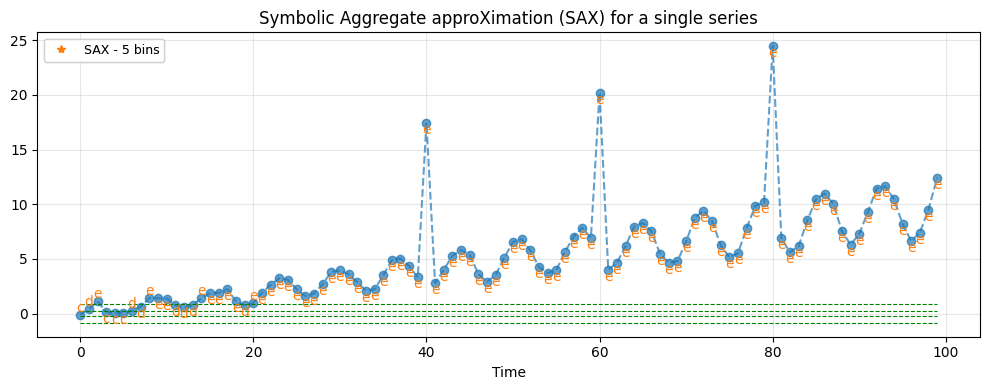

SAX string: cdecccddeeedddeeeeedeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee


In [44]:
x = np.asarray(ts_with_linear_trend_seasonality_and_variance, dtype=float)
X = x.reshape(1, -1)
n_timestamps = X.shape[1]

n_bins = 5
sax = SymbolicAggregateApproximation(n_bins=n_bins, strategy='normal')
X_sax = sax.fit_transform(X)

bins = norm.ppf(np.linspace(0, 1, n_bins + 1)[1:-1])

bottom_bool = np.r_[True, X_sax[0, 1:] > X_sax[0, :-1]]

plt.figure(figsize=(10, 4))
plt.plot(x, 'o--', label='Original', alpha=0.7)

for t, y, s, bottom in zip(range(n_timestamps), x, X_sax[0], bottom_bool):
    va = 'bottom' if bottom else 'top'
    plt.text(t, y, s, ha='center', va=va, fontsize=10, color='#ff7f0e')

plt.hlines(bins, 0, n_timestamps - 1, color='g', linestyles='--', linewidth=0.8)

sax_legend = mlines.Line2D([], [], color='#ff7f0e', marker='*',
                           linestyle='None', label=f'SAX - {n_bins} bins')
first_legend = plt.legend(loc="upper left", handles=[sax_legend], fontsize=9)
ax = plt.gca().add_artist(first_legend)

plt.xlabel('Time')
plt.title('Symbolic Aggregate approXimation (SAX) for a single series')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

sax_string = ''.join(X_sax[0])
print("SAX string:", sax_string)